# Support Vector Machines


<h2>Introduction</h2>
There are two parts to this lab session. 

1. A part on PEGASOS where you are asked to implement the stochastic version of PEGASOS

2. A part on features mapping

Data are 2D. You can visualize them by running the following cell (red dots are labeled -1 and green dots are labeled 1).

data/dataset1.txt


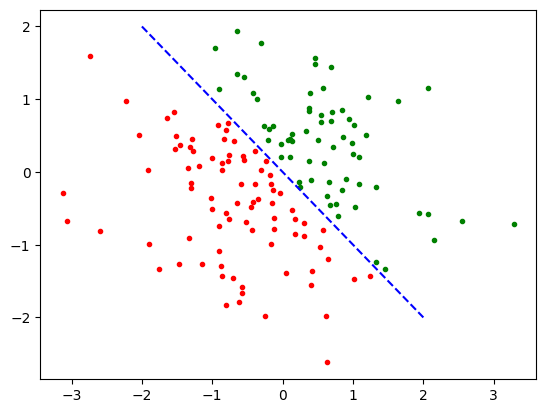

data/dataset2.txt


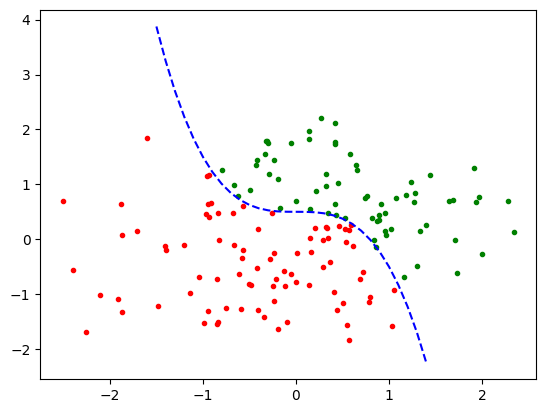

data/dataset3.txt


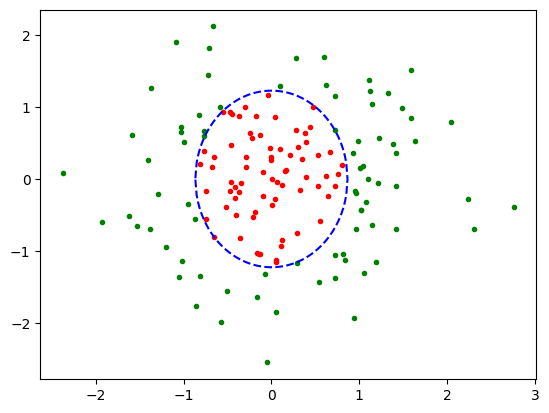

data/dataset4.txt


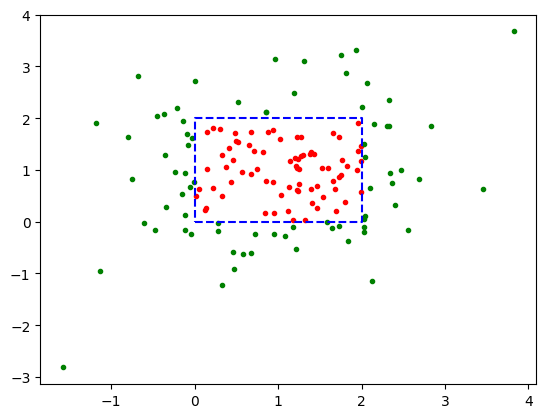

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt, cos, pi
import pandas as pd

# print the datasets and their delimiters
datasets = ["data/dataset" + str(x) + ".txt" for x in range(1, 5)]
for dataset in datasets :
    print(dataset)
    points_df=pd.read_csv(dataset,delimiter=' ')
    plt.plot(points_df.x_1[points_df.y==-1],points_df.x_2[points_df.y==-1],'r.') # points whose target y is -1
    plt.plot(points_df.x_1[points_df.y==1],points_df.x_2[points_df.y==1],'g.') # points whose target y is +1
    # draw exact delimiter
    if dataset == datasets[0]:
        plt.plot(np.array([0,40])/10-2,-np.array([0,40])/10+2, 'b--')
    elif dataset == datasets[1]:
        plt.plot([x/10-1.5 for x in range(30)], [0.5-((x/10)-1.5)**3 for x in range(30)], 'b--')
    elif dataset == datasets[2]:
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [-np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
    elif dataset == datasets[3]:
        plt.plot([x/8 for x in range(17)] + [2 for x in range(17)] + [(2-x/8) for x in range(17)] + [0 for x in range(17)],
             [0 for y in range(17)] + [y/8 for y in range(17)] + [2 for y in range(17)] + [(2-y/8) for y in range(17)], 'b--')
    plt.show()
    

### Question 0.1
According to the above plots, do these datasets seem to be linearly separable? On which of these datasets do you expect a linear SVM to perform well? On which ones do you think it will perform badly?

__Your answer here:__  
_According to the above plots, do these datasets seem to be linearly separable?_  
Datasets 1 seems to be linearly separable but datasets 2, 3 and 4 do not seem to be linearly seperable in 2D. Because:
1. It is seperable by a straight line
2. It is seperable by a polynom of degree 3 -> not linear
3. Its seperation boundary has 2 y-values for x=0 -> not linear
3. Its seperation boundary has 2 y-values for x=1 -> not linear

_On which of these datasets do you expect a linear SVM to perform well? On which ones do you think it will perform badly?_  
1. This is a linearly seperable problem in 2D, so we would expect a SVM to be able to solve this classification problem very good.
2. Pure SVM without mappings won't be able to solve the problem very well since the data is not linearly separable. Using a polynomial kernel we can transform this problem into a linearly seperable problem that SVM can solve.
3. Pure SVM without mappings won't be able to solve the problem very well since the data is not linearly separable. We can add a dimension with the transformation `axis_3 = axis_1^2 + axis_2^2` (distance of the datapoint from the origin). This makes the problem linearly seperable exploiting the new dimension.
4. Pure SVM without mappings won't be able to solve the problem very well since the data is not linearly separable. We can add a dimension with a transformation of this kind to make the problem linearly seperable:  
```Python
    def is_in_square(point):
        VERTEX0 = [0, 0]
        VERTEX1 = [2, 2]
        return VERTEX0[0] < point.x_1 < VERTEX1[0] and VERTEX0[1] < point.x_2 < VERTEX1[1]

    x_3 = d4.apply(is_in_square, axis = 1)
```

<h2>Part 1: PEGASOS</h2>

<h3>How PEGASOS works</h3>

<i>That sub-part gives some intuition about how PEGASOS can actually find the solution of a problem cast by a linear SVM. Reading it is not required to do the lab, but we encourage you to have a look at it as it may help you for your implementation.</i>

Let us assume that given a set $S = \lbrace (x_i, y_i) \rbrace$ where $x_i \in \mathbb{R}^n$ and $y_i \in \lbrace -1, 1 \rbrace$, we want to find a solution of the following problem

$$\min_{w, b} \frac{1}{2} \Vert w \Vert^2 + C \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $C$ is a non-zero hyperparameter controlling the "softness" of the margin (the lower the $C$ the softer the margin), or equivalently

$$\min_{w, b} \frac{\lambda}{2} \Vert w \Vert^2 + \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $\lambda$ replaces $C$ (the higher the $\lambda$ the softer the margin). We can get rid of the bias term $b$ by adding a constant feature to all the $x_i$ (we can assume without loss of generality that the value of the constant is 1) and by replacing $w$ by the concatenation of $w$ and $b$. In that setup, the optimization problem becomes (with $\tilde{w} = [w; b]$ and $\tilde{x_i} = [x_i; 1]$)

$$\min_{\tilde{w}} \frac{\lambda}{2} \Vert \tilde{w} \Vert^2 + \sum_i \max(0, 1-y_i(\tilde{w}^T\tilde{x_i})).$$

You can notice that the optimization problem we obtained is slightly different from the one we stated before, as $\Vert \tilde{w} \Vert^2$ should be replaced by $\Vert \tilde{w} \Vert^2 - b^2$. However, in practice, that difference has very few importance. Therefore in the following we will assume that $x_i \in \mathbb{R}^{n+1}$, $w \in \mathbb{R}^{n+1}$, and that the last feature of $x_i$ is always equal to 1. As we will work on the stochastic variant of PEGASOS, we will consider the following objective:

$$\min_{w_t} \frac{\lambda}{2} \Vert w_t \Vert^2 + \max(0, 1-y_{i_t}(w_t^Tx_{i_t}))$$

where $(x_{i_t}, y_{i_t})$ is a sample drawn randomly at iteration $t$ from $S$. The sub-gradient of the above objective is then given by:

$$\nabla w_t = \lambda w_t - \phi_I(x_{i_t}, y_{i_t}) y_{i_t}x_{i_t}$$

where $\phi_I$ is the indicator function of the set $I = \lbrace (x, y) \in R^d \times \lbrace -1, 1 \rbrace : y w^Tx < 1 \rbrace$ ($\phi_I(x, y) = 1$ if $(x, y) \in I$ and $\phi_I(x, y) = 0$ otherwise). Then, we compute $w_{t+1}$ using the following update formula:

$$w_{t+1} = w_t - \eta_t \nabla w_t$$

where $\eta_t = 1/(\lambda t)$. The algorithm stops after a predefined number of iterations. As you can understand, PEGASOS uses a stochastic gradient descent with learning rate $\eta_t$ to find the optimal parameters of an SVM. The next sub-part gives you a pseudo-code of PEGASOS. Your role will be to implement it based on that pseudo-code.

<h3>Pseudo-code of PEGASOS</h3>

Your task will now be to implement PEGASOS. An SVM class has been defined in utils.py. You are strongly encouraged to read it carefully to understand it.

### Exercise 1.1
Complete the following implementation of PEGASOS.

In [2]:
from utils import SVM, Dataset
from numpy.random import default_rng

def train(self, n_iterations, lambda_w, print_every_k=None,verbose=False):
    '''
    Train function for an SVM model using PEGASOS.
    If verbose is TRUE print the accuracy every 'print_every_k' iterations

    INPUTS:
    - self containing in particular:
        self.train_dataset with inside
            self.train_dataset.input -> inputs in a numpy NxD array, N number of sample, D dimensions
            self.train_dataset.output -> outputs in a numpy X array
        self.w -> weights of the model initialized at random before. Length D+1, because 1 is the bias
    - n_iterations -> total number of epochs
    - lambda_w -> lambda in PEGASOS
    - print_every_k -> compute the accuracy of the model every 'print_every_k' epochs
    - verbose -> if TRUE, in addition of computing the accuracy, the model also print it every 'print_every_k' epochs
    '''

    
    if not print_every_k:
        print_every_k = max(1, int(n_iterations/50))
        self.print_step=print_every_k
    
    rng = default_rng()
    # For n_iterations epochs
    for i in range(n_iterations): # equivalent for t in {1,...,T}
        
        # ! REMEMBER TO UPDATE self.w AT THE END OF EVERY ITERATION
        # ! self.train_dataset.input DOES NOT CONTAIN THE BIAS : a '1' in the dimension D+1
            # REMBER TO ADD THE '1' OF THE BIAS TO YOUR x VECTOR OR YOU WILL HAVE A SIZE MISMATCH
            # ADD THE BIAS IN THE LAST POSITION OF YOUR x VECTOR, OTHERWISE THE REST OF THE TRAIN WILL BE WRONG
            # x VECTOR OF [self.train_dataset.input[sample,:], 1]
        
        ################ YOUR CODE HERE #################
        index = int(rng.uniform(0, self.train_dataset.len))
        sample = self.train_dataset.input[index]
        sample = np.concatenate((sample, [1]))
        sample_label = self.train_dataset.output[index]
        
        eta_t = 1.0/(lambda_w * (i+1))
        if sample_label * np.dot(sample, self.w) < 1.0:
            self.w = self.w - eta_t*(lambda_w * self.w - sample_label * sample)
        else:
            self.w = self.w - eta_t * lambda_w * self.w
        
        ################ END OF YOUR CODE ###############
        
        if not i%print_every_k:
            if verbose:
                print("Epoch: ", i+1, " out of ", n_iterations)
                self.print_accuracy()
            else:
                self.compute_accuracy()
                    
SVM.train = train                    

### Question Exercise 1.2
Test your implementation on the four datasets (train your SVM during 1500 iterations with $\lambda = 0.0001$).
You have to:

1. create 2 objects Dataset, with the train dataset and test dataset for each dataset in the folder data
2. initialize your SVM model with the 2 objects
3. use the train function of your SVM object to train it
4. use the make_plot function of your SVM object to make the plot of its accuracy
5. use the function print_accuracy of your SVM object to see the final training accuracy

data/dataset1


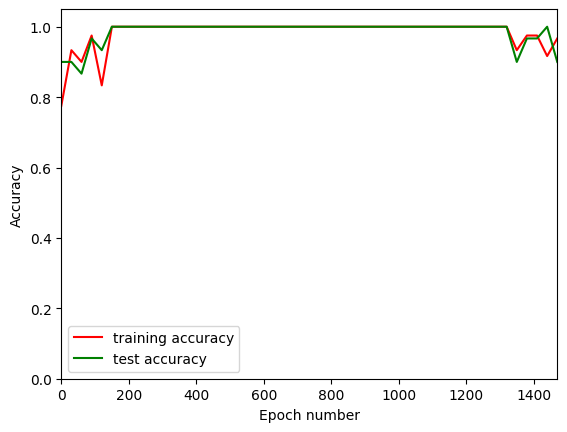

Accuracy: 100.0 %

data/dataset2


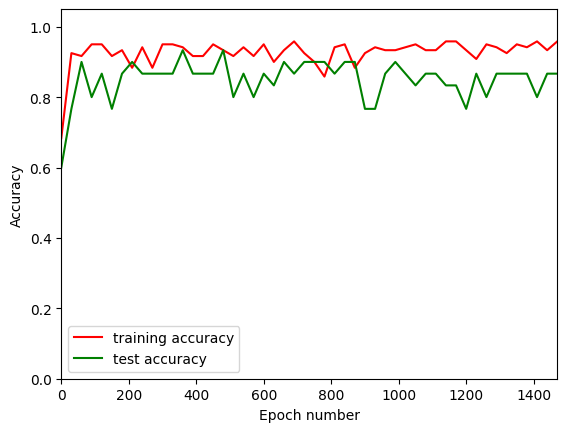

Accuracy: 95.83333333333334 %

data/dataset3


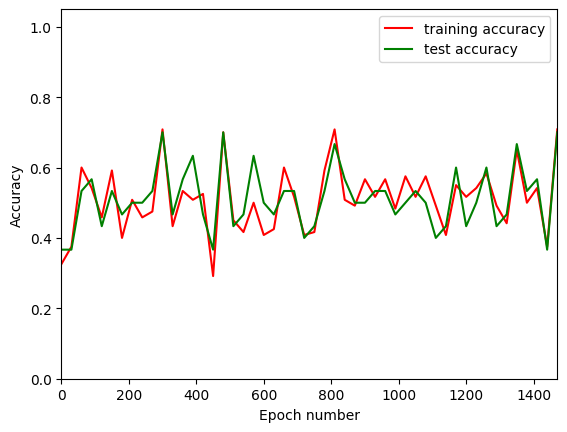

Accuracy: 55.833333333333336 %

data/dataset4


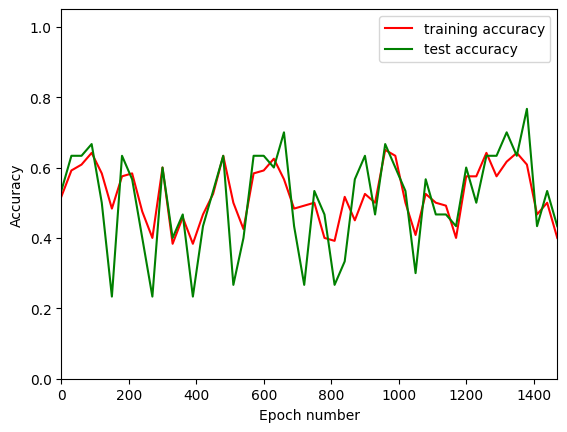

Accuracy: 46.666666666666664 %



In [3]:
for dataset in datasets:
    dataset = dataset.strip(".txt")
    print(dataset)
    train = Dataset(f"{dataset}_train.txt")
    test = Dataset(f"{dataset}_test.txt")

    svm = SVM(train, test)
    svm.train(n_iterations=1500, lambda_w=0.0001, print_every_k=None, verbose=False)

    svm.make_plot()
    svm.print_accuracy()
    print()

### Question 1.1
Do you find the results that you forecast in Question 0.1?

__Your answer here__

Yes, we find pretty much the results we expected, without using any kernel functions.  
But the SVM performs significantly better on the polynomial data than we would have expected, because a polynomial of degree 3 can be approximated not too bad by a straight line. It will only fail around the base of the function.

<h2>Part 2: Features Maps</h2>

As you know, it is possible to use the "Kernel Trick" to separate non-linearly separable datasets with SVMs. This trick is meant to be applied on the dual problem. As PEGASOS is based on the primal problem, the Kernel Trick cannot be used easily with PEGASOS. However, there is a method to approximate the feature space corresponding to a given kernel. In this part, you will implement and test that method. You will not be asked to dig into the mathematical theory behind that method, but if you wish, you can find more informations in the paper <i>Random Features for Large-Scale Kernel Machines</i> by Ali Rahimi and Ben Recht [1].

### Approximating the Radial Basis Function (RBF) kernel

The Radial Basis Function $K_\gamma$ is one of the most common kernels used with SVMs. It is defined as follows ($x, y \in \mathbb{R}^d$):

$$ K_\gamma(x, y) = \exp(-\gamma \Vert x - y \Vert^2).$$

Its feature space is of infinite dimension. However, you can approximate it according to the following algorithm (details in [1]):

```
INPUTS:
    S = {(x1, y1), ..., (xn, yn)}   # Dataset
    mean = zeros(d)
    cov = 2*d*gamma*eye(d)
    D = wanted dimension of the approximation of the RBF feature space

FEATURES_MAP(S, mean, sigma, D):
    S' = {}
    p ~ multivariate_normal_distribution(mean, cov)
    Draw D iid samples w1, ..., wD from p and D iid samples b1, ..., bD uniformly in [0, 2*pi]
    For all x in S:
        z = [cos(dot_product(w1, x) + b1), ..., cos(dot_product(wD, x) + bD)]
        z *= sqrt(2/D)
        Add z to S'
    Return S'
```

The pseudo-code above transforms data from its original space to a new feature space approximating the feature space corresponding to the RBF kernel. You will now implement that pseudo-code.

#### Exercise 2.1
Complete the following implementation of the FeaturesMap class.

In [4]:
import numpy as np
from utils import Dataset
from math import cos, pi
import random

class FeaturesMap:

    def __init__(self, D, d, gamma):
        '''
        INPUT:
        - d : old dimensions
        - D : new dimensions
        - gamma : softness/hardness parameter
        '''
        mean = np.zeros(d)
        cov = 2*d*gamma*np.eye(d)
        self.D = D
        self.w = np.array([np.random.multivariate_normal(mean, cov) for _ in range(D)])
        self.b = np.array([random.random()*2*pi for _ in range(D)])

    def __call__(self, dataset):
        outputs = dataset.output
        S_prime = [] # S'
        S=dataset.input
        for x in S:
            # compute z and append the values to S_prime keeping it as a list if you want
            
            ########## YOUR CODE HERE #################
            z = np.cos(self.w @ x + self.b)
            z *= np.sqrt(2.0/self.D)
            S_prime.append(z)
            ########## END OF YOUR CODE HERE ##########
            
        new_data = Dataset(input_size=self.D, length=dataset.len)
        new_data.input = np.array(S_prime)
        new_data.output = outputs
        
        return new_data

#### Exercise 2.2
Test your implementation on the four artificial datasets. Train your SVM during 1500 iterations with $\lambda = 0.0001$. The dimension of the feature space is 200 and $\gamma = 1$.

1. Create Dataset() objects for each train and test dataset
2. Move each train and test Dataset() object using FeaturesMap()
3. Init and train SVM with featured map model



Dataset 1


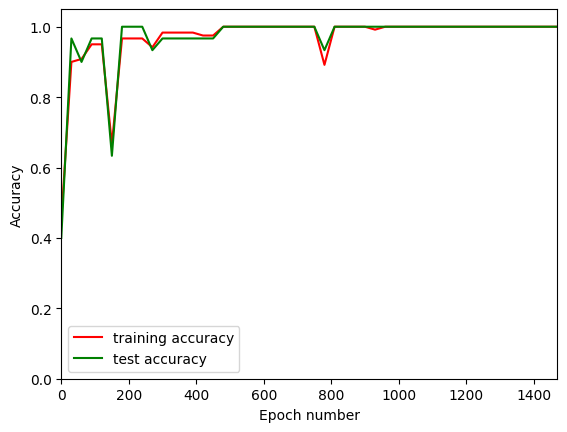

Accuracy: 100.0 %


Dataset 2


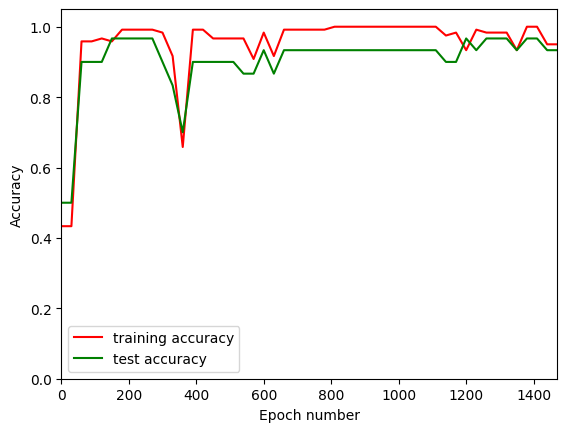

Accuracy: 95.0 %


Dataset 3


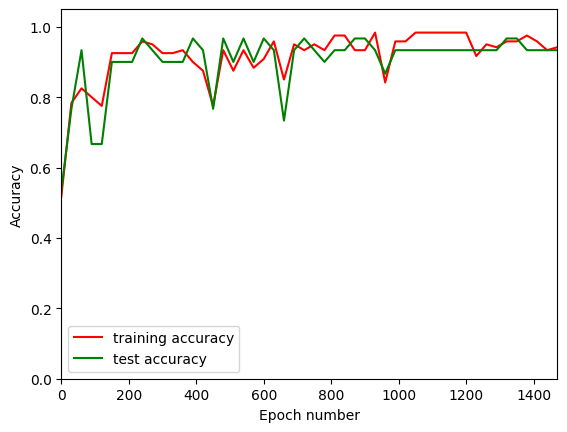

Accuracy: 97.5 %


Dataset 4


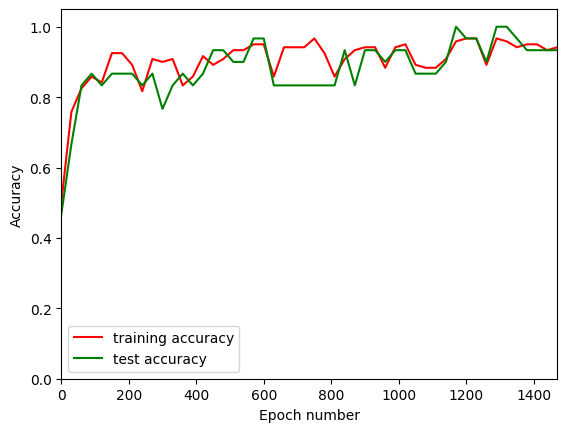

Accuracy: 95.83333333333334 %


In [5]:
n_iterations=1500
lambda_w = 0.0001
D=200
gamma=1

for i in range(1,5):
    print("\n\nDataset", i)
    datafile = "data/dataset"+str(i)+"_train.txt"
    train_data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)
    
    d=train_data.input_size

    features_map = FeaturesMap(D, d, gamma)
    new_train_data = features_map(train_data)
    new_test_data = features_map(test_data)
    
    # fit and train your SVM model using new_train_data and  new_test_data
    # then use make_plot() of your SVM object
    # then use print_accuracy() of your SVM object
    
    ############# YOUR CODE #############
    model = SVM(new_train_data, new_test_data)
    model.train(n_iterations, lambda_w)
    model.make_plot()
    model.print_accuracy()
    ########## END YOUR CODE ############ 


#### Question 2.1 
How do your results change with respect to what you found in Question 1.1?

__Your answer here__

The new model performs very well even with the last two datasets. For the first two datasets the results of the new model are really close to the ones without mapping, but for __datasets 3 and 4__ the accuracy jumps from lower than 50% to higher than __90%__.

### The role of $\gamma$ in the RBF kernel

#### Exercise 2.3
Do the same tests with $\gamma = 10^{-6}$. What do you notice? How can you explain your results?



Dataset 1


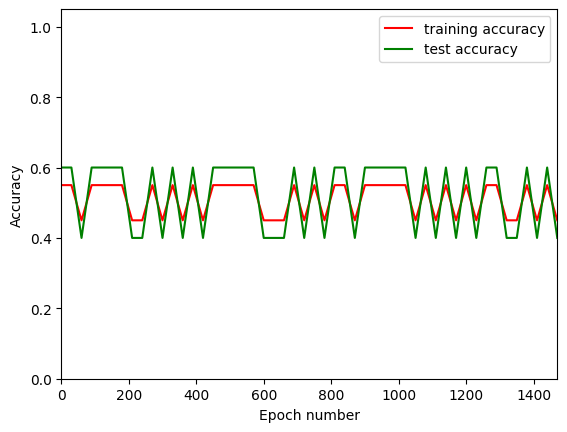

Accuracy: 55.00000000000001 %


Dataset 2


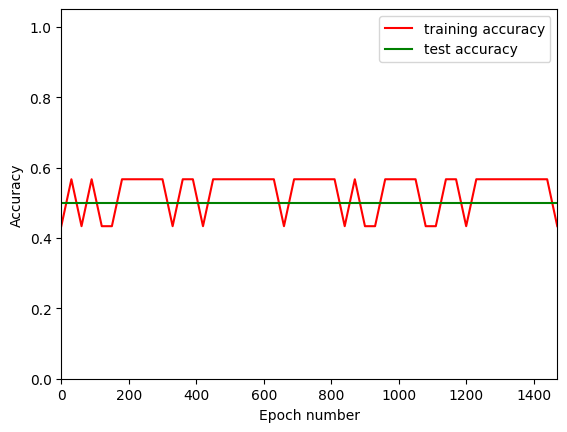

Accuracy: 43.333333333333336 %


Dataset 3


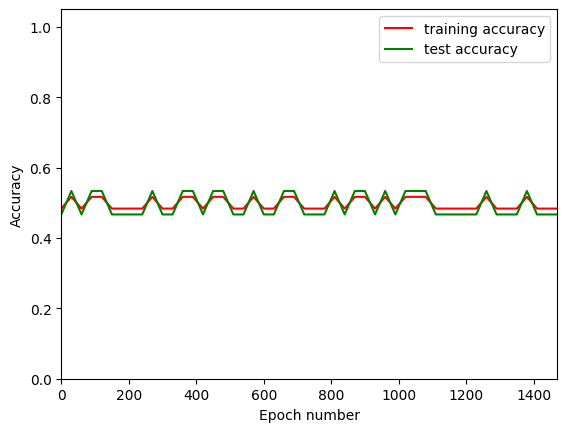

Accuracy: 48.333333333333336 %


Dataset 4


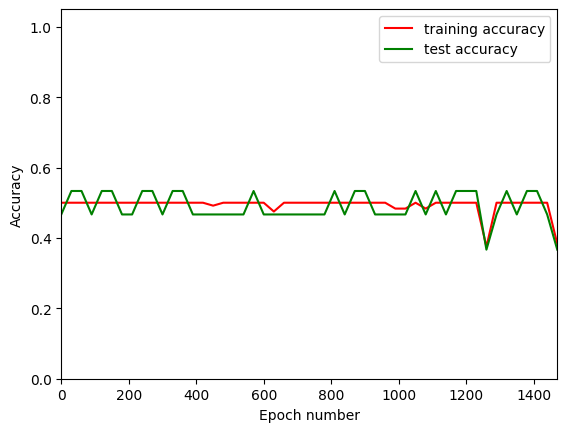

Accuracy: 50.0 %


In [6]:
n_iterations=1500
lambda_w = 0.0001
D=200
gamma=10e-6

for i in range(1,5):
    print("\n\nDataset", i)
    datafile = "data/dataset"+str(i)+"_train.txt"
    train_data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)
    
    d=train_data.input_size

    features_map = FeaturesMap(D, d, gamma)
    new_train_data = features_map(train_data)
    new_test_data = features_map(test_data)
    
    # fit and train your SVM model using new_train_data and  new_test_data
    # then use make_plot() of your SVM object
    # then use print_accuracy() of your SVM object
    
    ############# YOUR CODE #############
    model = SVM(new_train_data, new_test_data)
    model.train(n_iterations, lambda_w)
    model.make_plot()
    model.print_accuracy()
    ########## END YOUR CODE ############ 

__Answer__

# TODO: Not 100% sure, check
With $\gamma = 10^{-6}$ the models perform really poorly for all four datasets. Since $\gamma$ influences the covariance used during mapping, the resulting dataset contains values close to 0, with a low variance. The PEGASOS algorith then is not able to make progresses during the traing phase using the gradient descent because the steps performed at each iteretaion are too small.

#### Exercise 2.4
Do the same tests with $\gamma = 10^{4}$. What do you notice? How can you explain your results?



Dataset 1


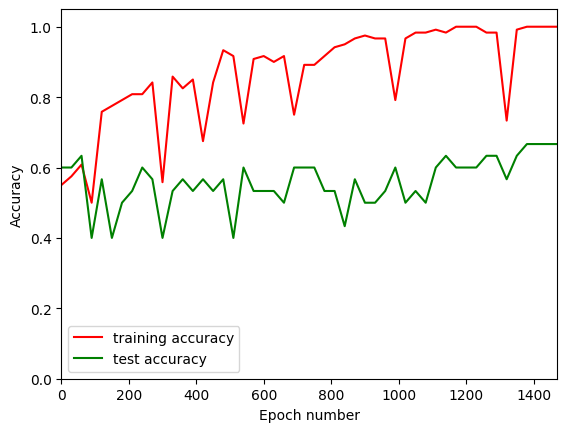

Accuracy: 100.0 %


Dataset 2


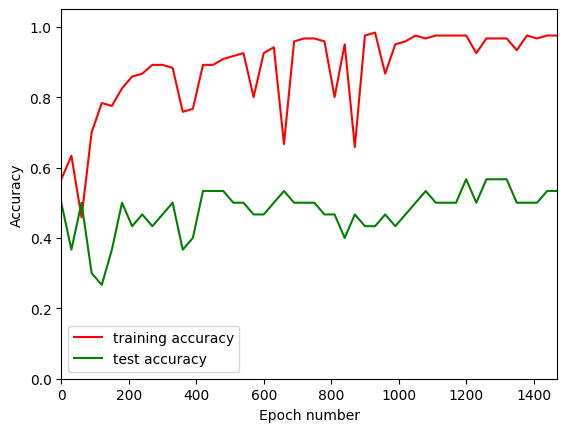

Accuracy: 98.33333333333333 %


Dataset 3


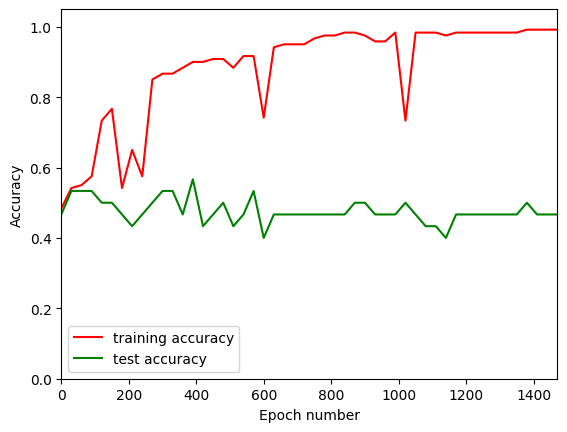

Accuracy: 100.0 %


Dataset 4


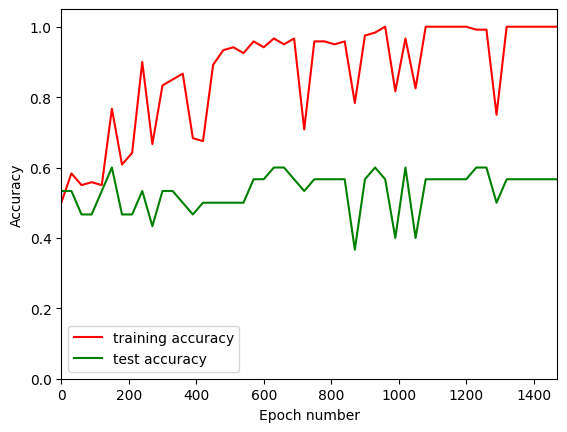

Accuracy: 100.0 %


In [7]:
n_iterations=1500
lambda_w = 0.0001
D=200
gamma=10e4

for i in range(1,5):
    print("\n\nDataset", i)
    datafile = "data/dataset"+str(i)+"_train.txt"
    train_data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)
    
    d=train_data.input_size

    features_map = FeaturesMap(D, d, gamma)
    new_train_data = features_map(train_data)
    new_test_data = features_map(test_data)
    
    # fit and train your SVM model using new_train_data and  new_test_data
    # then use make_plot() of your SVM object
    # then use print_accuracy() of your SVM object
    
    ############# YOUR CODE #############
    model = SVM(new_train_data, new_test_data)
    model.train(n_iterations, lambda_w)
    model.make_plot()
    model.print_accuracy()
    ########## END YOUR CODE ############ 

__Answer__

With $\gamma = 10^{4}$ the model is clearly overfitting the training data: the accuracy obtained with the training set is good but it is not reflected in the results obtained with the test set.